### Connect to Drive and importing dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pip install swifter

In [5]:
import pandas as pd
import numpy as np
import swifter
import re
from sklearn.model_selection import KFold
import statistics
import warnings
import seaborn as sns
from tqdm import tqdm
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None

In [8]:
train[train['label'] == 1]

,label,text
0,1.0,FUJIWARA no Chikamori ( year of birth and deat...
1,1.0,"Ryonen ( 1646 - October 29 , 1711 ) was a Budd..."
4,1.0,Iwanohimenomikoto ( year of birth unknown – Ju...
5,1.0,"YOSHIMINE no Nagamatsu ( 813 - December 30 , 8..."
6,1.0,"Hiizu MIYAKE ( November 1848 - March 16 , 1938..."
...,...,...
11273,1.0,"Sodo YAMAGUCHI ( June 1 , 1642 to September 30..."
11274,1.0,"Kakugoro INOUE ( November 30 , 1860 - Septembe..."
11276,1.0,Hakai ( The Broken Commandment ) is a full-l...
11279,1.0,"Sanemasa SHIGENOI ( May . 23 , 1700 - Dec.4 , ..."


### Read the data

In [6]:
pathTrain = "/content/drive/MyDrive/NLP Study Group/Problem 2/train.tsv"
pathTest = "/content/drive/MyDrive/NLP Study Group/Problem 2/test.tsv"

In [7]:
train = pd.read_csv(pathTrain, sep='\t', names=['label', 'text'])
train['label'] = train["label"].replace(-1,0).astype(float)
train

,label,text
0,1.0,FUJIWARA no Chikamori ( year of birth and deat...
1,1.0,"Ryonen ( 1646 - October 29 , 1711 ) was a Budd..."
2,0.0,A moat settlement is a village surrounded by a...
3,0.0,Fushimi Momoyama Athletic Park is located in M...
4,1.0,Iwanohimenomikoto ( year of birth unknown – Ju...
...,...,...
11282,1.0,"Aeba no Tsubone ( ? - June 4 , 1615 ) was a wo..."
11283,0.0,Yakizakana is a dish in which fish is broiled .
11284,0.0,An Ashigaru taisho was a commanding officer wh...
11285,0.0,Ecchu Kubo was a government which was establis...


In [ ]:
test = pd.read_csv(pathTest, sep='\t', names=['label','text'])
test['label'] = test["label"].replace(-1,0).astype(float)
test

In [ ]:
train['label'].value_counts()

0.0    6002
1.0    5285
Name: label, dtype: int64

In [ ]:
test['label'].value_counts()

0.0    1477
1.0    1346
Name: label, dtype: int64

### Class and Functions

In [ ]:
def tokenize(sentence): 
    return sentence.split()

In [ ]:
stopWordList = ['some', 'too', "don't", 'off', 'as', "you'll", 'yourselves', "should've", 'not', 're', 'how', 'mightn', 'both', 'because', "you're", 'what', "mustn't", 'm', 'any', 'hadn', 'have', 'you', 'who', 'the', 'such', "doesn't", 'are', 'she', 'ourselves', "you've", 'while', 'having', "isn't", 'himself', 'just', 'during', 'doesn', "won't", 'doing', "mightn't", 'out', 'wouldn', 'an', 'your', 'were', 'd', 'these', 'same', "aren't", 'didn', 'above', 'do', 'will', 'those', 'was', 'below', 'more', 'again', 'whom', 'couldn', 'before', "it's", 'from', 'ma', 'been', 'weren', 'through', 'they', 'isn', 'had', 'until', 's', 'y', 'shan', "wouldn't", 'now', 'my', 'all', "weren't", 'to', 'its', 'and', 'he', 'that', 'should', "couldn't", 'about', 'this', "hadn't", 'him', 'own', "haven't", 'under', 'themselves', 'here', 'wasn', 'we', 'did', 'o', "shan't", 'between', 'haven', 'which', "needn't", 'than', "you'd", 'ours', 'there', 'by', 'won', 'his', 'yourself', 'very', 'myself', 'up', 'needn', 'i', 'itself', 'aren', 'hers', 'further', 'herself', 'their', 'can', "shouldn't", 'mustn', 'but', 'few', 'or', 't', 'other', "wasn't", 'our', 'after', 'in', 'ain', 'theirs', 'be', 'a', 'does', 'am', 'me', "didn't", 'most', "she's", 'for', 'against', 'her', 've', 'why', "hasn't", 'has', 'only', 'down', 'don', 'with', 'at', 'over', 'into', 'it', 'once', 'them', 'is', 'of', 'yours', 'shouldn', 'nor', 'if', 'so', 'where', "that'll", 'hasn', 'each', 'll', 'when', 'then', 'on', 'being']

def stopWordRemover(sentence):
    tokens = sentence.split(" ")
    tokens_filtered= [word for word in tokens if not word in stopWordList]
    return (" ").join(tokens_filtered)

In [ ]:
def multiWhiteSpaceCorrector(sentence):
  if sentence is not None:
    correction = " ".join(sentence.split())
    return correction
  else:
    return sentence

In [ ]:
def ngramCounter(pandasSeriesOfSentence, n):
  words = (pandasSeriesOfSentence.str.split(' ').explode())
  tempGram = (words)
  for i in range(n-1):
    nextWord = words.groupby(level=0).shift(i*-1-1)
    tempGram = (tempGram + " " + nextWord)

  tempGram.dropna()

  df = tempGram.value_counts()[:-1]
  df = df.to_frame('count').rename_axis('word').reset_index()
  return df

In [ ]:
def outerJoin(dataframe1, dataframe2, minDataFrame1Occurence):
  outerJoin = pd.merge(dataframe1[dataframe1["count"]> minDataFrame1Occurence], dataframe2, how='outer', on=['word','word'])
  outerJoin.fillna(0, inplace=True)
  outerJoin["percentagePD"] = outerJoin['count_x'] / (outerJoin['count_x'] + outerJoin['count_y'])
  return outerJoin

In [ ]:
def consecutiveUpperCaseCounter(sentence): #[A-Z]{2,} -> 2 or 3 is debatable since name as XI exist while name of company JR also exist. But yields same result
  return len(re.findall('[A-Z]{2,}', sentence))

In [ ]:
class LogisticRegression:
  def __init__(self):
    self._weights = []
    self._learningRate = 0.01
    self._epoch = 10
    self._x = []
    self._y = []  
  
  def linearFunction(self, data, weights):
    return np.dot(data, weights)


  def logisticFunction(self, linearResult):
    return 1 / ( 1 + np.exp(-(linearResult)))

  def updateWeights(self, weights, learningRate, x, y):
    temp = np.zeros(len(x))
    for i in range(len(weights)):
      d = (self.logisticFunction(self.linearFunction(x, weights)) - y) * x[i]
      temp[i] = weights[i] - (learningRate * d)
    
    return temp

  def logisticRegressionLoss(self, yPredicted, yActual): # this loss is used when data already normalised
    loss = -(yActual * np.log(yPredicted) + (1-yActual) * np.log(1-yPredicted))
    meanLoss = loss.mean()
    return meanLoss

  ################################# http://fa.bianp.net/blog/2019/evaluate_logistic/#mjx-eqn-eq%3Alogloss

  def logsig(self, x):
      """Compute the log-sigmoid function component-wise."""
      out = np.zeros_like(x)
      idx0 = x < -33
      out[idx0] = x[idx0]
      idx1 = (x >= -33) & (x < -18)
      out[idx1] = x[idx1] - np.exp(x[idx1])
      idx2 = (x >= -18) & (x < 37)
      out[idx2] = -np.log1p(np.exp(-x[idx2]))
      idx3 = x >= 37
      out[idx3] = -np.exp(-x[idx3])
      return out

  def logisticRegressionLoss2(self, linRes, yActual):
      yActual = np.asarray(yActual)
      return np.mean((1 - yActual) * linRes - self.logsig(linRes))
  #################################


  def logisticRegressionAccuracy(self, yPredicted, yActual):
    yPredicted = yPredicted.round().astype(int)
    yActual = yActual.round().astype(int)
    xor = yPredicted ^ yActual
    return np.count_nonzero(xor == 0)/len(xor)

  def fit(self, x, y, learningRate, epoch):
    self._x = x
    self._xlist = x.to_numpy()
    self._y = y
    self._ylist = y.to_numpy()
    self._learningRate = learningRate
    self._epoch = epoch

    featureCount = len(self._x.columns)
    self._weights = np.random.rand(featureCount)

    for epoch in range(self._epoch):
      listResult = []
      linResult = []

      for i in range(len(self._xlist)):

        listResult.append(self.logisticFunction(self.linearFunction(self._xlist[i], self._weights)))
        linResult.append(self.linearFunction(self._xlist[i], self._weights))
        self._weights = self.updateWeights(self._weights, 0.1, self._xlist[i], self._ylist[i])

      #print("epoch: ", epoch + 1, 
      #        #"\tloss: ", self.logisticRegressionLoss(np.asarray(listResult), self._ylist), # use this loss when data already normalised
      #        "\tloss: ", self.logisticRegressionLoss2(np.asarray(linResult), self._ylist),
      #        "\taccuracy: ", self.logisticRegressionAccuracy(np.asarray(listResult), self._ylist)
      #)

  def predict(self, x):
    x = x.to_numpy()
    if x.ndim == 2:
      listResult = []
      for i in range(len(x)):
        listResult.append(self.logisticFunction(self.linearFunction(x[i], self._weights)))

      return listResult
    else:   
      raise ValueError("Got array in dimension of " + str(x.ndim) + ", expecting array in a dimension of 2." )

### Preprocess data

In [ ]:
train['processed'] = train['text'].swifter.apply(lambda x: x.lower()) # lowercasing
train['processed'] = train["processed"].str.replace('[^\w\s]','') # remove punctuations
train['processed'] = train["processed"].str.replace('[0-9]','') # remove numbers
train['processed'] = train["processed"].swifter.apply(multiWhiteSpaceCorrector) # replace double space
train['tokenized'] = train["processed"].swifter.apply(tokenize)
train['processed'] = train["processed"].swifter.apply(stopWordRemover) # remove stopwords
train['length'] = train["processed"].swifter.apply(lambda x: len(x))
train['consecUpperCase'] = train["text"].swifter.apply(consecutiveUpperCaseCounter)

train.reset_index(drop=True, inplace=True)
train

In [ ]:
test['processed'] = test['text'].swifter.apply(lambda x: x.lower()) # lowercasing
test['processed'] = test["processed"].str.replace('[^\w\s]','') # remove punctuations
test['processed'] = test["processed"].str.replace('[0-9]','') # remove numbers
test['processed'] = test["processed"].swifter.apply(multiWhiteSpaceCorrector) # replace double space
test['tokenized'] = test["processed"].swifter.apply(tokenize)
test['processed'] = test["processed"].swifter.apply(stopWordRemover) # remove stopwords
test['length'] = test["processed"].swifter.apply(lambda x: len(x))
test['consecUpperCase'] = test["text"].swifter.apply(consecutiveUpperCaseCounter)

test.reset_index(drop=True, inplace=True)
test.head() 

### Thresholding word frequency (1-gram)

In [ ]:
dfFreqPD = ngramCounter(train['processed'][train['label'] == 1], 1)
dfFreqPD


,word,count
0,period,4327
1,no,1392
2,japanese,1155
3,unknown,1066
4,birth,1047
...,...,...
9421,sonyu,1
9422,chikamori,1
9423,komushi,1
9424,eri,1


In [ ]:
dfFreqNPD =  ngramCounter(train['processed'][train['label'] == 0], 1)
dfFreqNPD

,word,count
0,kyoto,1715
1,city,1429
2,prefecture,1158
3,japanese,1153
4,period,1057
...,...,...
16354,kyomitoge,1
16355,obiage,1
16356,kideranomiya,1
16357,nodate,1


In [ ]:
outerJoin(dfFreqPD, dfFreqNPD, 1)

,word,count_x,count_y,percentagePD
0,period,4327.0,1057.0,0.803678
1,no,1392.0,572.0,0.708758
2,japanese,1155.0,1153.0,0.500433
3,unknown,1066.0,15.0,0.986124
4,birth,1047.0,17.0,0.984023
...,...,...,...,...
17783,reach,0.0,1.0,0.000000
17784,kyomitoge,0.0,1.0,0.000000
17785,obiage,0.0,1.0,0.000000
17786,nodate,0.0,1.0,0.000000


### Thresholding word frequency (2-gram)
https://skeptric.com/ngram-python/

In [ ]:
dfFreqPD2 =  ngramCounter(train['processed'][train['label'] == 1], 2)
dfFreqPD2

,word,count
0,heian period,880
1,edo period,853
2,death unknown,602
3,year birth,600
4,birth death,560
...,...,...
25553,wakako year,1
25554,hachioji city,1
25555,oji naming,1
25556,paintings term,1


In [ ]:
dfFreqNPD2 =  ngramCounter(train['processed'][train['label'] == 0], 2)
dfFreqNPD2

,word,count
0,kyoto city,706
1,kyoto prefecture,605
2,ward kyoto,507
3,city kyoto,493
4,edo period,254
...,...,...
51074,karakaminoyashiro shrine,1
51075,coat crest,1
51076,state sadaijin,1
51077,sound stage,1


In [ ]:
outerJoin(dfFreqPD2, dfFreqNPD2, 1)

,word,count_x,count_y,percentagePD
0,heian period,880.0,171.0,0.837298
1,edo period,853.0,254.0,0.770551
2,death unknown,602.0,4.0,0.993399
3,year birth,600.0,9.0,0.985222
4,birth death,560.0,4.0,0.992908
...,...,...,...,...
54384,karakaminoyashiro shrine,0.0,1.0,0.000000
54385,coat crest,0.0,1.0,0.000000
54386,state sadaijin,0.0,1.0,0.000000
54387,sound stage,0.0,1.0,0.000000


### Thresholding word frequency (3-gram)
https://skeptric.com/ngram-python/

In [ ]:
dfFreqPD3 =  ngramCounter(train['processed'][train['label'] == 1], 3)
dfFreqPD3

,word,count
0,birth death unknown,537
1,japanese military commander,452
2,busho japanese military,405
3,year birth unknown,294
4,year birth death,276
...,...,...
33591,period member house,1
33592,january september feudal,1
33593,suzuki june retainer,1
33594,shoku nihongi collection,1


In [ ]:
dfFreqNPD3 =  ngramCounter(train['processed'][train['label'] == 0], 3)
dfFreqNPD3

,word,count
0,ward kyoto city,505
1,city kyoto prefecture,473
2,kyoto city kyoto,259
3,city nara prefecture,124
4,japanese feudal government,116
...,...,...
59079,also nick name,1
59080,gods enshrined munakatataisha,1
59081,tobaku movement refers,1
59082,oxdrawn carriage kind,1


In [ ]:
outerJoin(dfFreqPD3, dfFreqNPD3, 1)

,word,count_x,count_y,percentagePD
0,birth death unknown,537.0,4.0,0.992606
1,japanese military commander,452.0,3.0,0.993407
2,busho japanese military,405.0,3.0,0.992647
3,year birth unknown,294.0,5.0,0.983278
4,year birth death,276.0,2.0,0.992806
...,...,...,...,...
62330,also nick name,0.0,1.0,0.000000
62331,gods enshrined munakatataisha,0.0,1.0,0.000000
62332,tobaku movement refers,0.0,1.0,0.000000
62333,oxdrawn carriage kind,0.0,1.0,0.000000


### Thresholding word frequency (4-gram)
https://skeptric.com/ngram-python/

In [ ]:
dfFreqPD4 =  ngramCounter(train['processed'][train['label'] == 1], 4)
dfFreqPD4

,word,count
0,busho japanese military commander,404
1,year birth death unknown,270
2,sengoku period period warring,223
3,period period warring states,220
4,period northern southern courts,188
...,...,...
35567,yasuji inoue date birth,1
35568,period nara period japan,1
35569,yang school philosophy middle,1
35570,sojun presents insane unconventional,1


In [ ]:
dfFreqNPD4 =  ngramCounter(train['processed'][train['label'] == 0], 4)
dfFreqNPD4

,word,count
0,kyoto city kyoto prefecture,246
1,ward kyoto city kyoto,218
2,japanese feudal government headed,115
3,feudal government headed shogun,114
4,bakufu japanese feudal government,114
...,...,...
58442,called choyo no sekku,1
58443,no miya place soraku,1
58444,drama genre theater film,1
58445,tumulus currently designated mausoleum,1


In [ ]:
dfIntersect4 = pd.merge(dfFreqPD4[dfFreqPD4["count"] > 1], dfFreqNPD4, how='outer', on=['word','word'])
dfIntersect4.fillna(0, inplace=True)
dfIntersect4["percentagePD"] = dfIntersect4['count_x'] / (dfIntersect4['count_x'] + dfIntersect4['count_y'])
dfIntersect4.sort_values(by=['percentagePD'], ascending=False)
dfIntersect4

,word,count_x,count_y,percentagePD
0,busho japanese military commander,404.0,3.0,0.992629
1,year birth death unknown,270.0,2.0,0.992647
2,sengoku period period warring,223.0,23.0,0.906504
3,period period warring states,220.0,23.0,0.905350
4,period northern southern courts,188.0,26.0,0.878505
...,...,...,...,...
61338,called choyo no sekku,0.0,1.0,0.000000
61339,no miya place soraku,0.0,1.0,0.000000
61340,drama genre theater film,0.0,1.0,0.000000
61341,tumulus currently designated mausoleum,0.0,1.0,0.000000


## 5-Fold Cross Validation to Determine Best N-Gram Prob-Occ Combination

In [ ]:
kfold = KFold(n_splits = 5)
features = ["label", "length", "processed"]
trainFeatures = []
accList = []

numngrams = [1, 2, 3, 4]
probs = [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]
occs =  [5, 10, 15, 30, 50, 75, 100]
for ngrams in tqdm(numngrams):
  for prob in probs:
    for occ in occs:
      #print(str(ngrams)+" "+str(prob)+" "+str(occ))
      nGramsProbList = []
      minFreqPersonOccurenceList = []

      kfoldacc = []

      for i in range(0, ngrams):
          nGramsProbList.append(prob)
          minFreqPersonOccurenceList.append(occ)

      for indexTrain, indexTest in kfold.split(train):
        kftrain = train[features].loc[indexTrain]
        kfval = train[features].loc[indexTest] 

        for i in range(ngrams):
          #trainFeatures.append(str(i+1))
          trainFeatures = [str(i+1)]
          kftrain[str(i+1)] = 0
          kfval[str(i+1)] = 0

          freqPerson = ngramCounter(kftrain['processed'][kftrain['label'] == 1], i+1)
          freqNonPerson = ngramCounter(kftrain['processed'][kftrain['label'] == 0], i+1)
          dictFreq = outerJoin(freqPerson, freqNonPerson, minFreqPersonOccurenceList[i])
          dictFreq = dictFreq[dictFreq["percentagePD"] > nGramsProbList[i]]
          nGramList = dictFreq["word"].tolist()
          
          for ngram in nGramList:
            kftrain[str(i+1)][kftrain['processed'].str.contains(ngram)] += 1
            kfval[str(i+1)][kfval['processed'].str.contains(ngram)] += 1

          
        lr = LogisticRegression()
        lr.fit(kftrain[trainFeatures], kftrain['label'], 0.02, 5)

        
      kfoldacc.append(lr.logisticRegressionAccuracy(np.array(lr.predict(kfval[trainFeatures])), kfval['label']))
      # print("ngrams: "+str(ngrams)+" acc: "+str(statistics.mean(kfoldacc)))
     
      accList.append([ngrams, prob, occ, statistics.mean(kfoldacc)])

dfAcc = pd.DataFrame(accList, columns=['ngram', 'prob', 'minocc', 'acc'])
display(dfAcc)

100%|██████████| 4/4 [1:17:45<00:00, 1166.32s/it]


,ngram,prob,minocc,acc
0,1,0.6,5,0.470536
1,1,0.6,10,0.478068
2,1,0.6,15,0.479397
3,1,0.6,30,0.487373
4,1,0.6,50,0.636243
...,...,...,...,...
163,4,0.9,15,0.696943
164,4,0.9,30,0.658396
165,4,0.9,50,0.644661
166,4,0.9,75,0.619849


In [ ]:
# ngram 2 prob 0.9 minocc 5 0.8817013735046522
# ngram 1 prob 0.9 minocc 50 0.8697385910500665
# ngram 3 prob 0.75 minocc 5 0.8320779796189632
# ngram 4 prob 0.8 minocc 5 0.765618077093487

In [ ]:
dfAcc.to_excel("/content/drive/MyDrive/NLP Study Group/Problem 2/parameterTuning.xlsx")  

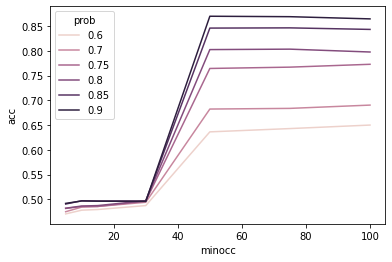

In [ ]:
sns.lineplot(data=dfAcc[dfAcc["ngram"] == 1], x = "minocc", y = "acc", hue = "prob")

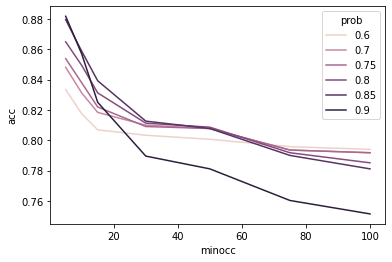

In [ ]:
sns.lineplot(data=dfAcc[dfAcc["ngram"] == 2], x = "minocc", y = "acc", hue = "prob")

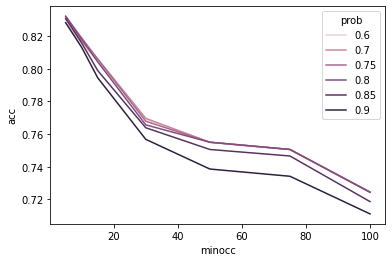

In [ ]:
sns.lineplot(data=dfAcc[dfAcc["ngram"] == 3], x = "minocc", y = "acc", hue = "prob")

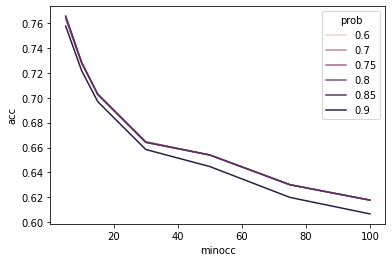

In [ ]:
sns.lineplot(data=dfAcc[dfAcc["ngram"] == 4], x = "minocc", y = "acc", hue = "prob")

## Train - Test

In [ ]:
# trained only with 1-4 gram
kfold = KFold(n_splits = 5)
features = ["label", "length", "processed"]
trainFeatures = []

ngrams = int(input("n-grams: "))
nGramsProbList = []
minFreqPersonOccurenceList = []

for i in range(0, ngrams):
    inp = float(input("probability of "+str(i+1)+"-gram: "))
    inp2 = int(input("minimum occurence of "+str(i+1)+"-gram: "))
    nGramsProbList.append(inp)
    minFreqPersonOccurenceList.append(inp2)

#for indexTrain, indexTest in kfold.split(train):
#  kftrain = train[features].loc[indexTrain]
#  kfval = train[features].loc[indexTest] 

for i in range(ngrams):
  trainFeatures.append(str(i+1))
  train[str(i+1)] = 0
  test[str(i+1)] = 0

  freqPerson = ngramCounter(train['processed'][train['label'] == 1], i+1)
  freqNonPerson = ngramCounter(train['processed'][train['label'] == 0], i+1)
  dictFreq = outerJoin(freqPerson, freqNonPerson, minFreqPersonOccurenceList[i])
  dictFreq = dictFreq[dictFreq["percentagePD"] > nGramsProbList[i]]
  nGramList = dictFreq["word"].tolist()
  
  for ngram in nGramList:
    train[str(i+1)][train['processed'].str.contains(ngram)] += 1
    test[str(i+1)][test['processed'].str.contains(ngram)] += 1

  
lr = LogisticRegression()
lr.fit(train[trainFeatures], train['label'], 0.02, 5)

print(lr.logisticRegressionAccuracy(np.array(lr.predict(test[trainFeatures])), test['label']))


n-grams: 4
probability of 1-gram: 0.9
minimum occurence of 1-gram: 50
probability of 2-gram: 0.9
minimum occurence of 2-gram: 5
probability of 3-gram: 0.75
minimum occurence of 3-gram: 5
probability of 4-gram: 0.8
minimum occurence of 4-gram: 5
0.8675168260715551


In [ ]:
# 4-gram + length
kfold = KFold(n_splits = 5)
features = ["label", "length", "processed"]
trainFeatures = ['length']

ngrams = int(input("n-grams: "))
nGramsProbList = []
minFreqPersonOccurenceList = []

for i in range(0, ngrams):
    inp = float(input("probability of "+str(i+1)+"-gram: "))
    inp2 = int(input("minimum occurence of "+str(i+1)+"-gram: "))
    nGramsProbList.append(inp)
    minFreqPersonOccurenceList.append(inp2)

#for indexTrain, indexTest in kfold.split(train):
#  kftrain = train[features].loc[indexTrain]
#  kfval = train[features].loc[indexTest] 

for i in range(ngrams):
  trainFeatures.append(str(i+1))
  train[str(i+1)] = 0
  test[str(i+1)] = 0

  freqPerson = ngramCounter(train['processed'][train['label'] == 1], i+1)
  freqNonPerson = ngramCounter(train['processed'][train['label'] == 0], i+1)
  dictFreq = outerJoin(freqPerson, freqNonPerson, minFreqPersonOccurenceList[i])
  dictFreq = dictFreq[dictFreq["percentagePD"] > nGramsProbList[i]]
  nGramList = dictFreq["word"].tolist()
  
  for ngram in nGramList:
    train[str(i+1)][train['processed'].str.contains(ngram)] += 1
    test[str(i+1)][test['processed'].str.contains(ngram)] += 1

  
lr = LogisticRegression()
lr.fit(train[trainFeatures], train['label'], 0.02, 5)

print(lr.logisticRegressionAccuracy(np.array(lr.predict(test[trainFeatures])), test['label']))


n-grams: 4
probability of 1-gram: 0.9
minimum occurence of 1-gram: 50
probability of 2-gram: 0.9
minimum occurence of 2-gram: 5
probability of 3-gram: 0.75
minimum occurence of 3-gram: 5
probability of 4-gram: 0.8
minimum occurence of 4-gram: 5
0.8685795253276656


In [ ]:
# 4-gram + consecUpperCase
kfold = KFold(n_splits = 5)
features = ["label", "length", "processed"]
trainFeatures = ['consecUpperCase']

ngrams = int(input("n-grams: "))
nGramsProbList = []
minFreqPersonOccurenceList = []

for i in range(0, ngrams):
    inp = float(input("probability of "+str(i+1)+"-gram: "))
    inp2 = int(input("minimum occurence of "+str(i+1)+"-gram: "))
    nGramsProbList.append(inp)
    minFreqPersonOccurenceList.append(inp2)

#for indexTrain, indexTest in kfold.split(train):
#  kftrain = train[features].loc[indexTrain]
#  kfval = train[features].loc[indexTest] 

for i in range(ngrams):
  trainFeatures.append(str(i+1))
  train[str(i+1)] = 0
  test[str(i+1)] = 0

  freqPerson = ngramCounter(train['processed'][train['label'] == 1], i+1)
  freqNonPerson = ngramCounter(train['processed'][train['label'] == 0], i+1)
  dictFreq = outerJoin(freqPerson, freqNonPerson, minFreqPersonOccurenceList[i])
  dictFreq = dictFreq[dictFreq["percentagePD"] > nGramsProbList[i]]
  nGramList = dictFreq["word"].tolist()
  
  for ngram in nGramList:
    train[str(i+1)][train['processed'].str.contains(ngram)] += 1
    test[str(i+1)][test['processed'].str.contains(ngram)] += 1

  
lr = LogisticRegression()
lr.fit(train[trainFeatures], train['label'], 0.02, 5)

print(lr.logisticRegressionAccuracy(np.array(lr.predict(test[trainFeatures])), test['label']))


n-grams: 4
probability of 1-gram: 0.9
minimum occurence of 1-gram: 50
probability of 2-gram: 0.9
minimum occurence of 2-gram: 5
probability of 3-gram: 0.75
minimum occurence of 3-gram: 5
probability of 4-gram: 0.8
minimum occurence of 4-gram: 5
0.8855827134254339


In [ ]:
# combining length, consecUpperCase, 1-gram 2-gram 3-gram and 4-gram increased the result
kfold = KFold(n_splits = 5)
features = ["label", "length", "processed"]
trainFeatures = ['length', 'consecUpperCase']

ngrams = int(input("n-grams: "))
nGramsProbList = []
minFreqPersonOccurenceList = []

for i in range(0, ngrams):
    inp = float(input("probability of "+str(i+1)+"-gram: "))
    inp2 = int(input("minimum occurence of "+str(i+1)+"-gram: "))
    nGramsProbList.append(inp)
    minFreqPersonOccurenceList.append(inp2)

#for indexTrain, indexTest in kfold.split(train):
#  kftrain = train[features].loc[indexTrain]
#  kfval = train[features].loc[indexTest] 

for i in range(ngrams):
  trainFeatures.append(str(i+1))
  train[str(i+1)] = 0
  test[str(i+1)] = 0

  freqPerson = ngramCounter(train['processed'][train['label'] == 1], i+1)
  freqNonPerson = ngramCounter(train['processed'][train['label'] == 0], i+1)
  dictFreq = outerJoin(freqPerson, freqNonPerson, minFreqPersonOccurenceList[i])
  dictFreq = dictFreq[dictFreq["percentagePD"] > nGramsProbList[i]]
  nGramList = dictFreq["word"].tolist()
  
  for ngram in nGramList:
    train[str(i+1)][train['processed'].str.contains(ngram)] += 1
    test[str(i+1)][test['processed'].str.contains(ngram)] += 1

  
lr = LogisticRegression()
lr.fit(train[trainFeatures], train['label'], 0.02, 5)

print(lr.logisticRegressionAccuracy(np.array(lr.predict(test[trainFeatures])), test['label']))


n-grams: 4
probability of 1-gram: 0.9
minimum occurence of 1-gram: 50
probability of 2-gram: 0.9
minimum occurence of 2-gram: 5
probability of 3-gram: 0.75
minimum occurence of 3-gram: 5
probability of 4-gram: 0.8
minimum occurence of 4-gram: 5
0.8813319164009918


In [ ]:
# baseline when only using consecutive uppercase
kfold = KFold(n_splits = 5)
features = ["label", "length", "processed"]
trainFeatures = ['consecUpperCase']

ngrams = int(input("n-grams: "))
nGramsProbList = []
minFreqPersonOccurenceList = []

for i in range(0, ngrams):
    inp = float(input("probability of "+str(i+1)+"-gram: "))
    inp2 = int(input("minimum occurence of "+str(i+1)+"-gram: "))
    nGramsProbList.append(inp)
    minFreqPersonOccurenceList.append(inp2)

#for indexTrain, indexTest in kfold.split(train):
#  kftrain = train[features].loc[indexTrain]
#  kfval = train[features].loc[indexTest] 

  
lr = LogisticRegression()
lr.fit(train[trainFeatures], train['label'], 0.02, 5)

print(lr.logisticRegressionAccuracy(np.array(lr.predict(test[trainFeatures])), test['label']))


n-grams: 1
probability of 1-gram: 1
minimum occurence of 1-gram: 1
0.8104852993269571


In [ ]:
# combining length, consecUpperCase, 1-gram 2-gram 3-gram and removing 4-gram increased the result
kfold = KFold(n_splits = 5)
features = ["label", "length", "processed"]
trainFeatures = ['length', 'consecUpperCase']

ngrams = int(input("n-grams: "))
nGramsProbList = []
minFreqPersonOccurenceList = []

for i in range(0, ngrams):
    inp = float(input("probability of "+str(i+1)+"-gram: "))
    inp2 = int(input("minimum occurence of "+str(i+1)+"-gram: "))
    nGramsProbList.append(inp)
    minFreqPersonOccurenceList.append(inp2)

#for indexTrain, indexTest in kfold.split(train):
#  kftrain = train[features].loc[indexTrain]
#  kfval = train[features].loc[indexTest] 

for i in range(ngrams):
  trainFeatures.append(str(i+1))
  train[str(i+1)] = 0
  test[str(i+1)] = 0

  freqPerson = ngramCounter(train['processed'][train['label'] == 1], i+1)
  freqNonPerson = ngramCounter(train['processed'][train['label'] == 0], i+1)
  dictFreq = outerJoin(freqPerson, freqNonPerson, minFreqPersonOccurenceList[i])
  dictFreq = dictFreq[dictFreq["percentagePD"] > nGramsProbList[i]]
  nGramList = dictFreq["word"].tolist()
  
  for ngram in nGramList:
    train[str(i+1)][train['processed'].str.contains(ngram)] += 1
    test[str(i+1)][test['processed'].str.contains(ngram)] += 1

  
lr = LogisticRegression()
lr.fit(train[trainFeatures], train['label'], 0.02, 5)

print(lr.logisticRegressionAccuracy(np.array(lr.predict(test[trainFeatures])), test['label']))


n-grams: 3
probability of 1-gram: 0.9
minimum occurence of 1-gram: 50
probability of 2-gram: 0.9
minimum occurence of 2-gram: 5
probability of 3-gram: 0.75
minimum occurence of 3-gram: 5
0.9096705632306057


In [ ]:
# combining length, consecUpperCase, 1-gram 2-gram and removing 3-gram increased the result
kfold = KFold(n_splits = 5)
features = ["label", "length", "processed"]
trainFeatures = ['length', 'consecUpperCase']

ngrams = int(input("n-grams: "))
nGramsProbList = []
minFreqPersonOccurenceList = []

for i in range(0, ngrams):
    inp = float(input("probability of "+str(i+1)+"-gram: "))
    inp2 = int(input("minimum occurence of "+str(i+1)+"-gram: "))
    nGramsProbList.append(inp)
    minFreqPersonOccurenceList.append(inp2)

#for indexTrain, indexTest in kfold.split(train):
#  kftrain = train[features].loc[indexTrain]
#  kfval = train[features].loc[indexTest] 

for i in range(ngrams):
  trainFeatures.append(str(i+1))
  train[str(i+1)] = 0
  test[str(i+1)] = 0

  freqPerson = ngramCounter(train['processed'][train['label'] == 1], i+1)
  freqNonPerson = ngramCounter(train['processed'][train['label'] == 0], i+1)
  dictFreq = outerJoin(freqPerson, freqNonPerson, minFreqPersonOccurenceList[i])
  dictFreq = dictFreq[dictFreq["percentagePD"] > nGramsProbList[i]]
  nGramList = dictFreq["word"].tolist()
  
  for ngram in nGramList:
    train[str(i+1)][train['processed'].str.contains(ngram)] += 1
    test[str(i+1)][test['processed'].str.contains(ngram)] += 1

  
lr = LogisticRegression()
lr.fit(train[trainFeatures], train['label'], 0.02, 5)

print(lr.logisticRegressionAccuracy(np.array(lr.predict(test[trainFeatures])), test['label']))


n-grams: 2
probability of 1-gram: 0.9
minimum occurence of 1-gram: 50
probability of 2-gram: 0.9
minimum occurence of 2-gram: 5
0.916400991852639


In [ ]:
# trained with only 1-gram, the result is so so
kfold = KFold(n_splits = 5)
features = ["label", "length", "processed"]
trainFeatures = ['length', 'consecUpperCase']

ngrams = int(input("n-grams: "))
nGramsProbList = []
minFreqPersonOccurenceList = []

for i in range(0, ngrams):
    inp = float(input("probability of "+str(i+1)+"-gram: "))
    inp2 = int(input("minimum occurence of "+str(i+1)+"-gram: "))
    nGramsProbList.append(inp)
    minFreqPersonOccurenceList.append(inp2)

#for indexTrain, indexTest in kfold.split(train):
#  kftrain = train[features].loc[indexTrain]
#  kfval = train[features].loc[indexTest] 

for i in range(ngrams):
  trainFeatures.append(str(i+1))
  train[str(i+1)] = 0
  test[str(i+1)] = 0

  freqPerson = ngramCounter(train['processed'][train['label'] == 1], i+1)
  freqNonPerson = ngramCounter(train['processed'][train['label'] == 0], i+1)
  dictFreq = outerJoin(freqPerson, freqNonPerson, minFreqPersonOccurenceList[i])
  dictFreq = dictFreq[dictFreq["percentagePD"] > nGramsProbList[i]]
  nGramList = dictFreq["word"].tolist()
  
  for ngram in nGramList:
    train[str(i+1)][train['processed'].str.contains(ngram)] += 1
    test[str(i+1)][test['processed'].str.contains(ngram)] += 1

  
lr = LogisticRegression()
lr.fit(train[trainFeatures], train['label'], 0.02, 5)

print(lr.logisticRegressionAccuracy(np.array(lr.predict(test[trainFeatures])), test['label']))


n-grams: 1
probability of 1-gram: 0.9
minimum occurence of 1-gram: 50
0.8537017357421183


In [ ]:
# however when only 2 grams is used, the accuracy is not as great as when i combined 1-gram and 2-gram
kfold = KFold(n_splits = 5)
features = ["label", "length", "processed"]
trainFeatures = ['length', 'consecUpperCase', "2"]

ngrams = int(input("n-grams: "))
nGramsProbList = []
minFreqPersonOccurenceList = []

for i in range(0, ngrams):
    inp = float(input("probability of "+str(i+1)+"-gram: "))
    inp2 = int(input("minimum occurence of "+str(i+1)+"-gram: "))
    nGramsProbList.append(inp)
    minFreqPersonOccurenceList.append(inp2)

#for indexTrain, indexTest in kfold.split(train):
#  kftrain = train[features].loc[indexTrain]
#  kfval = train[features].loc[indexTest] 

for i in range(ngrams):
  #trainFeatures.append(str(i+1))
  train[str(i+1)] = 0
  test[str(i+1)] = 0

  freqPerson = ngramCounter(train['processed'][train['label'] == 1], i+1)
  freqNonPerson = ngramCounter(train['processed'][train['label'] == 0], i+1)
  dictFreq = outerJoin(freqPerson, freqNonPerson, minFreqPersonOccurenceList[i])
  dictFreq = dictFreq[dictFreq["percentagePD"] > nGramsProbList[i]]
  nGramList = dictFreq["word"].tolist()
  
  for ngram in nGramList:
    train[str(i+1)][train['processed'].str.contains(ngram)] += 1
    test[str(i+1)][test['processed'].str.contains(ngram)] += 1

  
lr = LogisticRegression()
lr.fit(train[trainFeatures], train['label'], 0.02, 5)

print(lr.logisticRegressionAccuracy(np.array(lr.predict(test[trainFeatures])), test['label']))


n-grams: 2
probability of 1-gram: 0.9
minimum occurence of 1-gram: 50
probability of 2-gram: 0.9
minimum occurence of 2-gram: 5
0.7913567127169677
